# SEARCH ENGINE AND PREDICTIONS

In [1]:
import pandas as pd
import numpy as np
import pymongo
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import cufflinks as cf
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
%matplotlib inline
import collect_data

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import BaggingClassifier
from redis import Redis
from sklearn.externals import joblib


In [2]:
db=pymongo.MongoClient(host='54.187.166.119')

my_wiki_collection= db.my_wiki_database.my_wiki_collection
my_wiki_clean_collection= db.my_wiki_database.my_wiki_clean_collection

In [3]:
search_df=collect_data.get_clean_df()

In [4]:
search_df.head()

,Category,Content,Pageid,Subcategory,Title
0,machine learning,Machine learning is the subfield of computer s...,233488,machine learning,Machine learning
1,machine learning,The following outline is provided as an overvi...,53587467,machine learning,Outline of machine learning
2,machine learning,"In Machine Learning, if a statistical model is...",53198248,machine learning,Singular statistical model
3,machine learning,The accuracy paradox for predictive analytics ...,3771060,machine learning,Accuracy paradox
4,machine learning,Action model learning (sometimes abbreviated a...,43808044,machine learning,Action model learning


In [5]:
le=LabelEncoder()
target=le.fit_transform(search_df['Category'])

In [6]:
tfidf_vectorizer= TfidfVectorizer(min_df=1, stop_words='english')
document_term_matrix= tfidf_vectorizer.fit_transform(search_df['Content'])

SVD= TruncatedSVD(200)
lsa= SVD.fit_transform(document_term_matrix)

# Wikipedia Categories

In [7]:
search_df['Category'].value_counts()

technology               2151
machine learning         1256
linear algebra           1077
sleep                     990
memory                    763
business intelligence     759
emotions                  649
diets                     631
Name: Category, dtype: int64

# Wikipedia Article Recommender

In [8]:
# insert search term below
search_term_vec = tfidf_vectorizer.transform(['ketones'])
search_term_lsa = SVD.transform(search_term_vec)

cosine_similarities = lsa.dot(search_term_lsa.T).ravel()

results= cosine_similarities.argsort()[:-6:-1]

for result in results:
    print(search_df.ix[result])

Category                                                   diets
Content        Low-carbohydrate diets or low-carb diets are d...
Pageid                                                    459560
Subcategory                               Low-carbohydrate diets
Title                                      Low-carbohydrate diet
Name: 2447, dtype: object
Category                                                   diets
Content        Low-carbohydrate diets or low-carb diets are d...
Pageid                                                    459560
Subcategory                                            Fad diets
Title                                      Low-carbohydrate diet
Name: 2322, dtype: object
Category                                                   diets
Content        Low-carbohydrate diets or low-carb diets are d...
Pageid                                                    459560
Subcategory                                                diets
Title                                 

C:\Users\Papasmurfff\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



# RandomForest

In [24]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
params= {'n_estimators': [200,250,300],
        }

sss=StratifiedShuffleSplit(train_size=.7, test_size=.25, n_splits=5)

In [60]:
gs_rf = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=sss, n_jobs=-1)

gs_rf.fit(lsa, target)

In [146]:
joblib.dump(gs_rf , 'gs_rf')

['gs_rf']

In [62]:
gs_rf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [65]:
pd.DataFrame(gs_rf.cv_results_)[pd.DataFrame(gs_rf.cv_results_)['rank_test_score']==1]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,31.386255,0.219183,0.893765,0.993026,300,{'n_estimators': 300},1,0.888835,0.992232,0.892218,...,0.896085,0.993268,0.886419,0.993786,0.905268,0.992922,2.713374,0.041394,0.006609,0.000507


In [ ]:
rf_test_score=pd.DataFrame(gs_rf.cv_results_)[pd.DataFrame(gs_rf.cv_results_)['rank_test_score']==1]['mean_test_score'][2]
rf_test_score

# Bagging Trees

In [52]:
params={'n_estimators':[100,200,300]}

In [53]:
gs_bt=GridSearchCV(BaggingClassifier(RandomForestClassifier(),n_jobs=-1), param_grid=params, cv=sss, n_jobs=1)

In [54]:
gs_bt.fit(lsa, target)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.25,
            train_size=0.7),
       error_score='raise',
       estimator=BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_..._estimators=10, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [147]:
joblib.dump(gs_bt , 'gs_bt')

['gs_bt']

In [55]:
pd.DataFrame(gs_bt.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,19.487460,2.144519,0.882649,0.989988,100,{'n_estimators': 100},1,0.889802,0.989297,0.870469,...,0.880135,0.989988,0.888352,0.990506,0.884485,0.990333,0.625474,0.080938,0.006953,0.000423
1,42.841052,3.625085,0.882069,0.990022,200,{'n_estimators': 200},3,0.889802,0.989815,0.869502,...,0.876752,0.988952,0.888352,0.990506,0.885935,0.990506,3.669843,0.277386,0.007751,0.000592
2,69.098551,5.953151,0.882359,0.990368,300,{'n_estimators': 300},2,0.890768,0.989988,0.870469,...,0.878202,0.989815,0.886902,0.990333,0.885452,0.991024,2.094380,0.403228,0.007205,0.000442


In [ ]:
bt_test_score=pd.DataFrame(gs_bt.cv_results_)[pd.DataFrame(gs_bt.cv_results_)['rank_test_score']==1]['mean_test_score'][0]


# Logistic Regression

In [26]:
params= {'C': np.linspace(10,3000,50),
         'penalty': ['l1', 'l2'],
         
        }

sss=StratifiedShuffleSplit(train_size=.7, test_size=.25, n_splits=5)

In [28]:
gs_lr = GridSearchCV(LogisticRegression(), param_grid=params, cv=sss, n_jobs=-1)

gs_lr.fit(lsa, target)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.25,
            train_size=0.7),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([   10.     ,    71.02041,   132.04082,   193.06122,   254.08163,
         315.10204,   376.12245,   437.14286,   498.16327,   559.18367,
         620.20408,   681.22449,   742.2449 ,   803.26531,   864.28571,
         925.30612,   986.32653,  1047.34694,  1108.36735,  1169.38...,
        2755.91837,  2816.93878,  2877.95918,  2938.97959,  3000.     ]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [314]:
pd.DataFrame(gs_lr.cv_results_)[pd.DataFrame(gs_lr.cv_results_)['rank_test_score']==1]

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_penalty,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
9,5.019448,0.002808,0.903722,0.938719,254.082,l2,"{'C': 254.081632653, 'penalty': 'l2'}",1,0.905268,0.939582,...,0.903818,0.938892,0.898018,0.936993,0.903818,0.939927,0.271957,0.000401,0.003183,0.001047


In [ ]:
lr_test_score=pd.DataFrame(gs_lr.cv_results_)[pd.DataFrame(gs_lr.cv_results_)['rank_test_score']==1]['mean_test_score'][9]


# KNN

In [37]:
params= { 'n_neighbors':[1,2,3,4,5,]}
sss=StratifiedShuffleSplit(train_size=.7, test_size=.25, n_splits=5)

In [38]:
gs_knn= GridSearchCV(KNeighborsClassifier(), param_grid=params, cv=sss, n_jobs=-1)
gs_knn.fit(lsa, target)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.25,
            train_size=0.7),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [149]:
joblib.dump(gs_knn, 'gs_knn')

['gs_knn']

In [39]:
pd.DataFrame(gs_knn.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.137221,5.416704,0.849299,0.993199,1,{'n_neighbors': 1},4,0.846786,0.992577,0.859352,...,0.840986,0.994303,0.851136,0.994649,0.848236,0.991714,0.007918,0.072388,0.006017,0.001106
1,0.155413,6.618401,0.834026,0.926221,2,{'n_neighbors': 2},5,0.834219,0.925772,0.834703,...,0.825036,0.926290,0.842919,0.924219,0.833253,0.927499,0.012687,0.434240,0.005674,0.001189
2,0.170153,7.825008,0.852779,0.920663,3,{'n_neighbors': 3},3,0.851619,0.919040,0.853552,...,0.845819,0.920594,0.856452,0.919385,0.856452,0.924909,0.004355,0.133950,0.003934,0.002188
3,0.169953,8.022532,0.855196,0.911410,4,{'n_neighbors': 4},2,0.854036,0.911790,0.858869,...,0.853069,0.910927,0.859352,0.909373,0.850652,0.912653,0.004552,0.078025,0.003385,0.001173
4,0.175869,8.140947,0.857129,0.902468,5,{'n_neighbors': 5},1,0.854519,0.900397,0.858869,...,0.853069,0.904022,0.856936,0.903332,0.862252,0.903332,0.011826,0.134500,0.003244,0.001390


In [ ]:
knn_test_score=pd.DataFrame(gs_knn.cv_results_)[pd.DataFrame(gs_knn.cv_results_)['rank_test_score']==1]['mean_test_score'][4]



# Summary of Model Scores

In [340]:
model_test_df=pd.DataFrame(columns=['Model', 'Test Score'], index=range(4))

In [341]:
models=['KNN', 'Random Forest', 'Bagging Trees', 'Logistic Regression']
test_scores=[knn_test_score,rf_test_score , bt_test_score, lr_test_score ]

In [342]:
model_test_df['Model']=models
model_test_df['Test Score']= test_scores

In [343]:
model_test_df

,Model,Test Score
0,KNN,0.857129
1,Random Forest,0.893765
2,Bagging Trees,0.882649
3,Logistic Regression,0.903722


# Logistic Regression on various SVD n_components

In [319]:
n_components= [15,25,40,125,400,900,1400]
test_scores=[]
for components in n_components:     
    tfidf_vectorizer= TfidfVectorizer(min_df=1, stop_words='english')
    document_term_matrix= tfidf_vectorizer.fit_transform(search_df['Content'])

    SVD= TruncatedSVD(components)
    lsa= SVD.fit_transform(document_term_matrix)

    lr = GridSearchCV(LogisticRegression(), param_grid={'C':[250]}, cv=sss, n_jobs=-1)

    lr.fit(lsa, target)
    
    test_scores.append(pd.DataFrame(lr.cv_results_)['mean_test_score'][0])




In [331]:
SVD_df=pd.DataFrame(columns=['n_components', 'test_scores'], index=range(len(n_components)))

SVD_df['n_components']= n_components
SVD_df['test_scores']= test_scores

In [332]:
SVD_df

,n_components,test_scores
0,15,0.845239
1,25,0.882165
2,40,0.886999
3,125,0.900628
4,400,0.907395
5,900,0.895892
6,1400,0.896568


## Explained Variance

<Container object of 1400 artists>

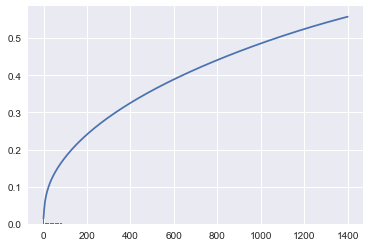

In [189]:
tfidf_vectorizer_1400= TfidfVectorizer(min_df=1, stop_words='english')
document_term_matrix_1400= tfidf_vectorizer_1400.fit_transform(search_df['Content'])

SVD_1400= TruncatedSVD(1400)
lsa_1400= SVD_1400.fit_transform(document_term_matrix)

evr = SVD_1400.explained_variance_ratio_
x = list(range(len(evr)))
plt.plot(x, np.cumsum(evr))
plt.bar(x, evr)

# n-grams (1,2)

<Container object of 200 artists>

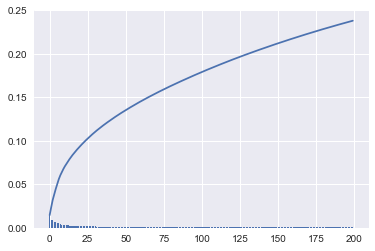

In [197]:
tfidf_vectorizer_ngrams= TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(1,2))
document_term_matrix_ngrams= tfidf_vectorizer_ngrams.fit_transform(search_df['Content'])

SVD_ngrams= TruncatedSVD(200)
lsa_ngrams= SVD_ngrams.fit_transform(document_term_matrix)

evr = SVD_ngrams.explained_variance_ratio_
x = list(range(len(evr)))
plt.plot(x, np.cumsum(evr))
plt.bar(x, evr)

In [198]:
document_term_matrix_ngrams.shape

(8276, 3031277)

In [199]:
gs_lr_ngrams = GridSearchCV(LogisticRegression(), param_grid={'C':[250]}, cv=sss, n_jobs=-1)

gs_lr_ngrams.fit(lsa_ngrams, target)

pd.DataFrame(gs_lr_ngrams.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,5.640865,0.037098,0.904592,0.935716,250,{'C': 250},1,0.908168,0.93285,0.898985,...,0.908652,0.934749,0.904785,0.938201,0.902368,0.937338,1.172187,0.02098,0.003625,0.001899


# n-grams (1,3)

<Container object of 200 artists>

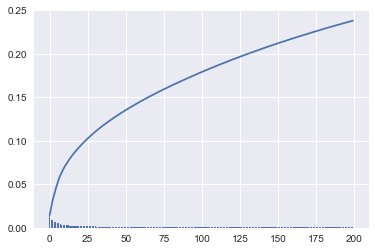

In [200]:
tfidf_vectorizer_ngrams3= TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(1,3))
document_term_matrix_ngrams3= tfidf_vectorizer_ngrams3.fit_transform(search_df['Content'])

SVD_ngrams3= TruncatedSVD(200)
lsa_ngrams3= SVD_ngrams3.fit_transform(document_term_matrix)

evr = SVD_ngrams3.explained_variance_ratio_
x = list(range(len(evr)))
plt.plot(x, np.cumsum(evr))
plt.bar(x, evr)

In [202]:
document_term_matrix_ngrams3.shape

(8276, 7264562)

In [201]:
gs_lr_ngrams3 = GridSearchCV(LogisticRegression(), param_grid={'C':[250]}, cv=sss, n_jobs=-1)

gs_lr_ngrams3.fit(lsa_ngrams3, target)

pd.DataFrame(gs_lr_ngrams3.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,5.486207,0.028969,0.908458,0.934714,250,{'C': 250},1,0.908168,0.93682,0.906718,...,0.922668,0.927844,0.896568,0.937166,0.908168,0.936302,1.204863,0.026298,0.008324,0.003484


In [255]:
feature_names= np.array(tfidf_vectorizer_40.get_feature_names())


# TFIDF no SVD

# n_gram = (1, 1)

In [247]:
gs_lr_all=GridSearchCV(LogisticRegression(), cv=sss, n_jobs=-1, param_grid={'C':[200000]})
gs_lr_all.fit(document_term_matrix_40, target)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.25,
            train_size=0.7),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [250, 2000, 20000, 1]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=0)

In [248]:
pd.DataFrame(gs_lr_all.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,24.560206,0.040810,0.900242,0.992888,250,{'C': 250},3,0.906718,0.993440,0.900435,...,0.899468,0.993268,0.887869,0.993958,0.906718,0.992232,0.784998,0.002428,0.006894,0.000876
1,29.298816,0.038603,0.901692,0.992888,2000,{'C': 2000},2,0.908652,0.993440,0.900918,...,0.900918,0.993268,0.889319,0.993958,0.908652,0.992232,1.588633,0.001052,0.007088,0.000876
2,35.870797,0.039405,0.903142,0.992888,20000,{'C': 20000},1,0.911068,0.993440,0.902368,...,0.901885,0.993268,0.892218,0.993958,0.908168,0.992232,1.577795,0.003968,0.006474,0.000876
3,10.565504,0.038202,0.854809,0.941378,1,{'C': 1},4,0.856936,0.941654,0.855002,...,0.852586,0.941999,0.840986,0.941826,0.868536,0.940618,1.206028,0.021803,0.008820,0.000563


## n-gram (1, 2)

In [281]:
tfidf_vectorizer_ngram= TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(1,2))
document_term_matrix_ngram= tfidf_vectorizer_ngram.fit_transform(search_df['Content'])



In [282]:
document_term_matrix_ngram.shape

(8276, 3031277)

In [285]:
gs_lr_all_ngram=GridSearchCV(LogisticRegression(), cv=sss, n_jobs=-1, param_grid={'C':[200000]})
gs_lr_all_ngram.fit(document_term_matrix_ngram, target)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=None, test_size=0.25,
            train_size=0.7),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1, param_grid={'C': [200000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [274]:
search_df['Category'].value_counts()

technology               2151
machine learning         1256
linear algebra           1077
sleep                     990
memory                    763
business intelligence     759
emotions                  649
diets                     631
Name: Category, dtype: int64

In [275]:
pd.Series(target).value_counts()

7    2151
4    1256
3    1077
6     990
5     763
0     759
2     649
1     631
dtype: int64

# Investigating Model Coefficients

## Category: Technology

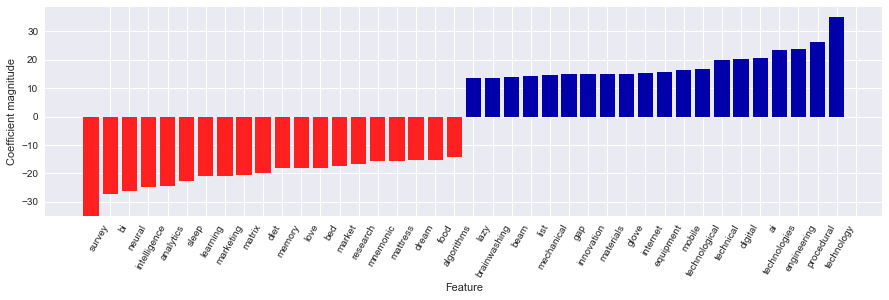

In [293]:
mglearn.tools.visualize_coefficients(gs_lr_all.best_estimator_.coef_[7], feature_names, n_top_features=20)

## Category: Machine Learning

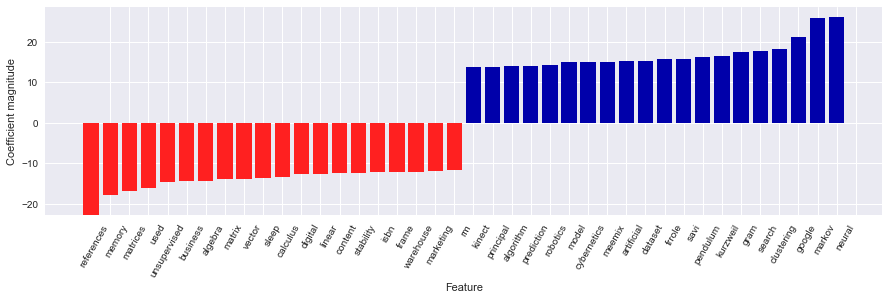

In [333]:
mglearn.tools.visualize_coefficients(gs_lr_all.best_estimator_.coef_[4], feature_names, n_top_features=20)

## Category: Linear Algebra

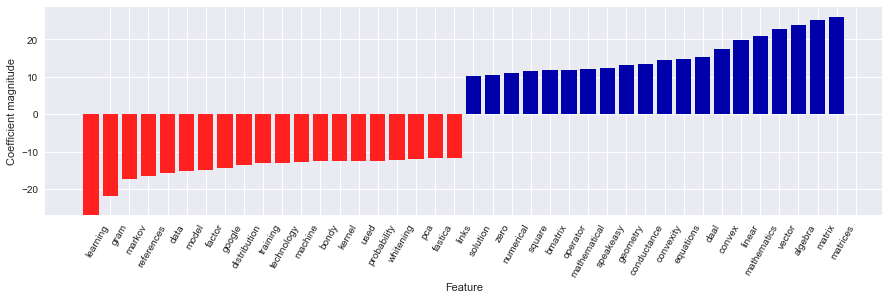

In [334]:
mglearn.tools.visualize_coefficients(gs_lr_all.best_estimator_.coef_[3], feature_names, n_top_features=20)

## Category: Sleep

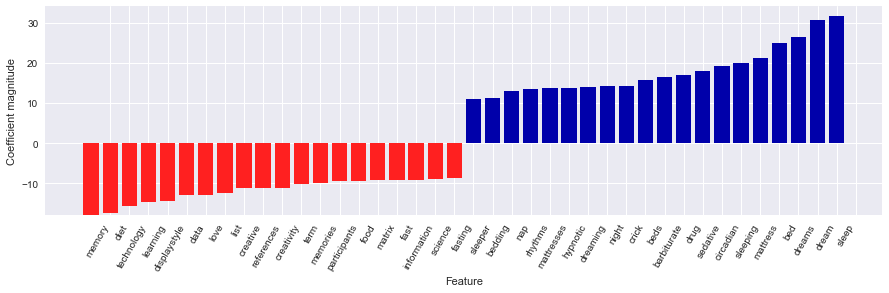

In [335]:
mglearn.tools.visualize_coefficients(gs_lr_all.best_estimator_.coef_[6], feature_names, n_top_features=20)

## Category: Memory

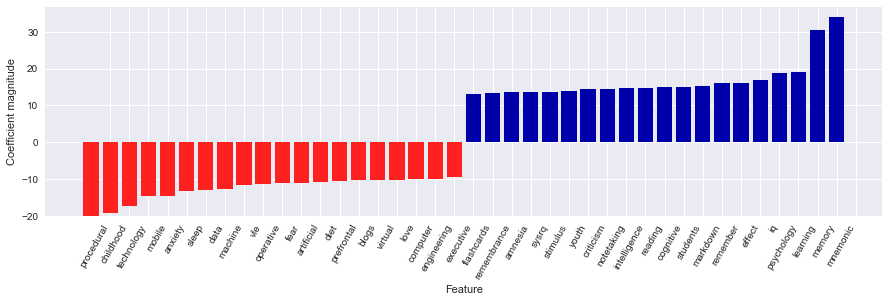

In [336]:
mglearn.tools.visualize_coefficients(gs_lr_all.best_estimator_.coef_[5], feature_names, n_top_features=20)

## Category: Business Intelligence

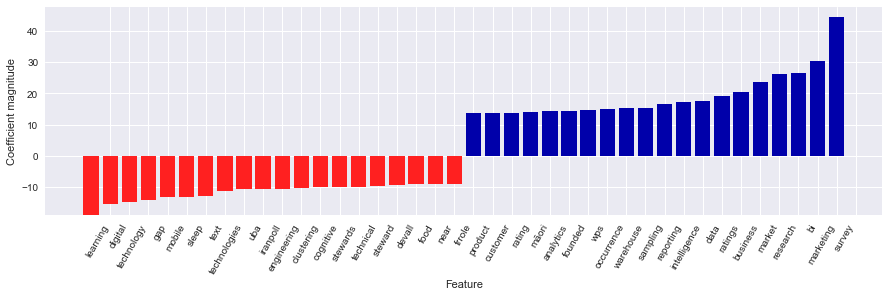

In [337]:
mglearn.tools.visualize_coefficients(gs_lr_all.best_estimator_.coef_[0], feature_names, n_top_features=20)

## Category: Emotions

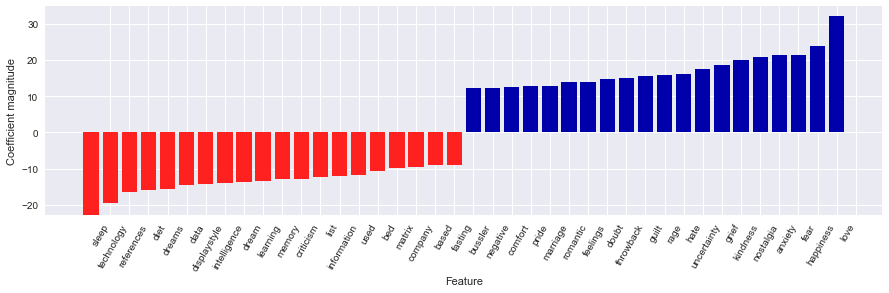

In [338]:
mglearn.tools.visualize_coefficients(gs_lr_all.best_estimator_.coef_[2], feature_names, n_top_features=20)

## Category: Diets

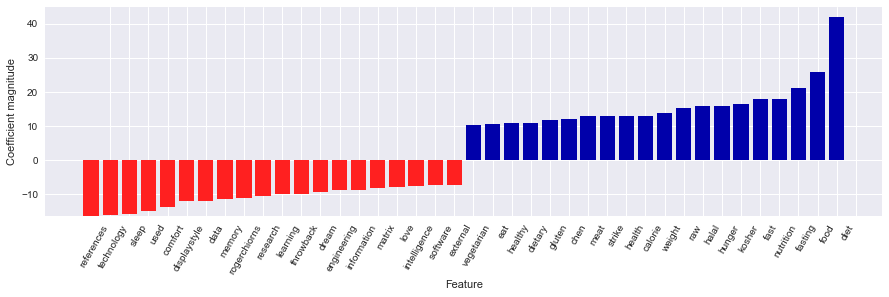

In [339]:
mglearn.tools.visualize_coefficients(gs_lr_all.best_estimator_.coef_[1], feature_names, n_top_features=20)